In [1]:
import os
import sklearn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/anomaly-detection-competition-ml1-ts-autumn-2022/train_groups.csv
/kaggle/input/anomaly-detection-competition-ml1-ts-autumn-2022/sample_submission.csv
/kaggle/input/anomaly-detection-competition-ml1-ts-autumn-2022/test_groups.csv
/kaggle/input/anomaly-detection-competition-ml1-ts-autumn-2022/docs_titles.tsv


In [2]:
!pip install gdown 

In [3]:
!gdown 1wlDnfyspFQqLW6t7bIgBGePA4P2GhZ0W

Downloading...
From: https://drive.google.com/uc?id=1wlDnfyspFQqLW6t7bIgBGePA4P2GhZ0W
To: /kaggle/working/docs_titles_lemmatized_cleaned.csv
100%|██████████████████████████████████████| 5.95M/5.95M [00:00<00:00, 31.9MB/s]


In [4]:
#titles = pd.read_csv('/kaggle/input/anomaly-detection-competition-ml1-ts-autumn-2022/docs_titles.tsv', sep='\t').set_index('doc_id').fillna(' ')
titles = pd.read_csv('/kaggle/working/docs_titles_lemmatized_cleaned.csv').set_index('doc_id').fillna(' ')
train_data = pd.read_csv('/kaggle/input/anomaly-detection-competition-ml1-ts-autumn-2022/train_groups.csv')
test_data = pd.read_csv('/kaggle/input/anomaly-detection-competition-ml1-ts-autumn-2022/test_groups.csv')

In [5]:
titles.head()

,title,lemmatized
doc_id,,
15731,ВАЗ 21213 | Замена подшипников ступицы | Нива,ваз 21213 замена подшипник ступица нива
14829,"Ваз 2107 оптом в Сочи. Сравнить цены, купить п...",ваз 2107 опт сочи сравнивать цена купить потре...
15764,Купить ступица Лада калина2. Трансмиссия - пер...,купить ступица лад калина2 трансмиссия переход...
17669,Классика 21010 - 21074,классика 21010 21074
14852,Ступица Нива — замена подшипника своими руками,ступица нива — замена подшипник свой рука


In [6]:
text_data = titles.drop('title', axis=1).to_dict('index')
for key in list(text_data.keys()):
    text_data[key] = text_data[key]['lemmatized'].split(' ')
    
text_data[15731]

['ваз', '21213', 'замена', 'подшипник', 'ступица', 'нива']

# Jaccard

In [69]:
def text_jaccard(text_1, text_2):
    x, y = set(text_1), set(text_2)
    z = x.intersection(y)
    u = x.union(y)
    return len(z) / len(u)

In [70]:
def jaccard_features(data, text_data, group_id, n_features=25, distance_features = None):
    
    group_data = data[data['group_id'] == group_id][['doc_id', 'pair_id']].to_numpy()

    if len(group_data) < n_features:
        print(f"Amount of smaples is {len(group_data)} less than {n_features}")
        n_features = len(group_data)
    
    if distance_features == None:
        distance_features = {}

    for i, (doc_1_id, pair_1_id) in enumerate(group_data):
        distances = np.zeros(len(group_data))
        if doc_1_id in text_data:
            for j, (doc_2_id, pair_2_id) in enumerate(group_data):
                if doc_2_id in text_data:
                    distances[j] = text_jaccard(text_data[doc_1_id], text_data[doc_2_id])
            
        
        distance_features[pair_1_id] = np.sort(distances).squeeze()[::-1][1:n_features + 1]
    
    return distance_features

In [71]:
train_jaccard = {}

for group_id in tqdm(train_data['group_id'].unique()):
    train_jaccard = jaccard_features(train_data, text_data, group_id=group_id, n_features=25, distance_features = train_jaccard)

100%|██████████| 129/129 [00:05<00:00, 23.84it/s]


In [72]:
test_jaccard = {}

for group_id in tqdm(test_data['group_id'].unique()):
    test_jaccard = jaccard_features(test_data, text_data, group_id=group_id, n_features=25, distance_features = test_jaccard)

100%|██████████| 180/180 [00:07<00:00, 23.65it/s]


In [75]:
with open("jaccard_train.pkl", "wb") as file:
    pickle.dump(train_jaccard, file)
    
with open("jaccard_test.pkl", "wb") as file:
    pickle.dump(test_jaccard, file)

# TF-IDF

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances


def vectorized_distances(data, text_data, group_id, n_features=25, distance_features = None):
    
    vectorizer = TfidfVectorizer(min_df=0)
    
    group_data = data[data['group_id'] == group_id][['doc_id', 'pair_id']].to_numpy()
    

    if len(group_data) < n_features:
        print(f"Amount of samples is {len(group_data)} less than {n_features}")
        n_features = len(group_data)
    
    if distance_features == None:
        distance_features = {}
    
    text_sample = []
    
    for i, (doc_id, pair_id) in enumerate(group_data):
        if doc_id in text_data:
            text_sample.append(' '.join(text_data[doc_id]))
        else:
            text_sample.append(' ')
    
    vectors = vectorizer.fit_transform(text_sample)
    
    euclidean_distances = pairwise_distances(vectors, metric='euclidean')
    cosine_distances = pairwise_distances(vectors, metric='cosine')
    
    euclidean_distances = np.sort(euclidean_distances, axis=1)[:, 1:n_features+1]
    cosine_distances = np.sort(cosine_distances, axis=1)[:, 1:n_features+1]
    
    for i, (doc_id, pair_id) in enumerate(group_data):
        distance_features[pair_id] = {
            'euclidean' : euclidean_distances[i],
            'cosine' : cosine_distances[i]}
    return distance_features

In [79]:
train_distances = {}

for group_id in tqdm(train_data['group_id'].unique()):
    train_distances = vectorized_distances(train_data, text_data, group_id=group_id, n_features=25, distance_features = train_distances)

100%|██████████| 129/129 [00:00<00:00, 141.12it/s]


In [80]:
test_distances = {}

for group_id in tqdm(test_data['group_id'].unique()):
    test_distances = vectorized_distances(test_data, text_data, group_id=group_id, n_features=25, distance_features = train_distances)

100%|██████████| 180/180 [00:01<00:00, 136.79it/s]


In [83]:
with open("distances_train.pkl", "wb") as file:
    pickle.dump(train_distances, file)
    
with open("distances_test.pkl", "wb") as file:
    pickle.dump(test_distances, file)

# KNN

In [150]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, log_loss

## Jaccard

In [143]:
pairs_id = list(train_jaccard.keys())
X_jaccard = []
y = []

for key in pairs_id:
    X_jaccard.append(train_jaccard[key])
    y.append(int(train_data[train_data['pair_id'] == key]['target']))

In [144]:
X_train, X_val, y_train, y_val = train_test_split(X_jaccard, y, test_size = 0.3)

In [120]:
score = []

for n in range(2, 10):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    score.append(f1_score(y_val, y_pred))

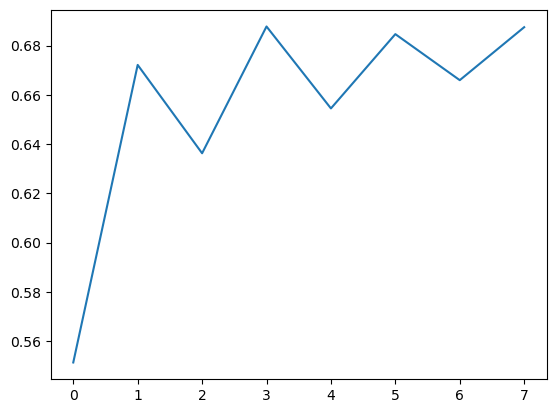

In [121]:
plt.plot(range(2, 10), score)

In [122]:
pairs_id = list(test_jaccard.keys())
X_test = []
y_test = []

for key in pairs_id:
    X_test.append(test_jaccard[key])

In [123]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_jaccard, y)

KNeighborsClassifier()

In [124]:
y_pred = knn.predict(X_test)

In [125]:
pairs_id = list(test_jaccard.keys())
submission = {}

for i, key in enumerate(pairs_id):
    submission[key] = y_pred[i]

In [139]:
submission_csv = pd.DataFrame.from_dict(submission, orient='index').reset_index().rename(columns={'index':'pair_id', 0:'target'})
submission_csv

,pair_id,target
0,11691,0
1,11692,0
2,11693,0
3,11694,1
4,11695,0
...,...,...
16622,28313,0
16623,28314,0
16624,28315,1
16625,28316,1


In [142]:
submission_csv.to_csv('submission_knn_jaccard.csv', index=False)

# Cosine

In [145]:
pairs_id = list(train_jaccard.keys())
X_cosine = []
X_euclidean = []
y = []

for key in pairs_id:
    X_cosine.append(train_distances[key]['cosine'])
    X_euclidean.append(train_distances[key]['euclidean'])
    y.append(int(train_data[train_data['pair_id'] == key]['target']))

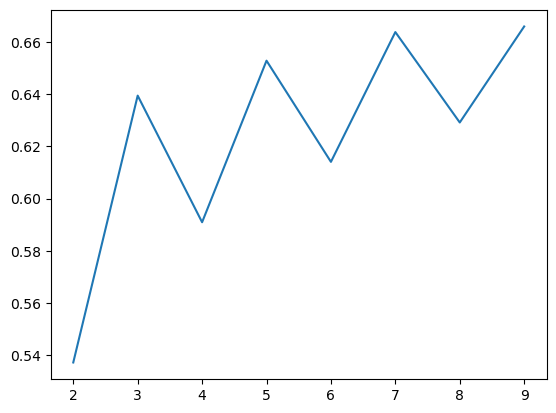

In [149]:
X_train, X_val, y_train, y_val = train_test_split(X_cosine, y, test_size = 0.3)

score = []

for n in range(2, 10):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    score.append(f1_score(y_val, y_pred))
    
plt.plot(range(2, 10), score)

## Euclidean

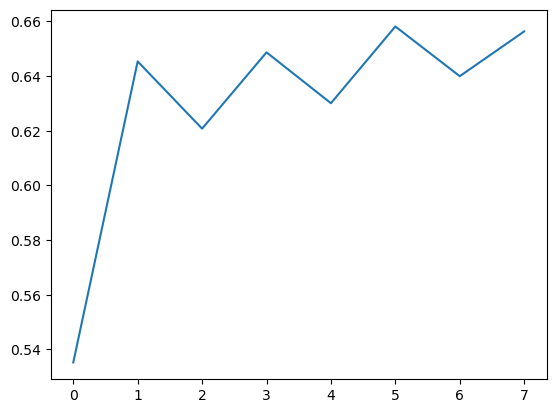

In [148]:
X_train, X_val, y_train, y_val = train_test_split(X_euclidean, y, test_size = 0.3)

score = []

for n in range(2, 10):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    score.append(f1_score(y_val, y_pred))
    
plt.plot(range(2, 10), score)